### Import

In [1]:
import pandas as pd
import json
import os 
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime , timedelta
import TransformData
from statsmodels.graphics.tsaplots import plot_acf

In this notebook, we do the data processing for token pairs (WETH vs USDC, USDT, DAI)on Arbitrum and Mainnet . And we can study the order flow, especially the arrival process and arrival time. Here we consider two fee tiers: 0.3% and 0.05%. 


# Arbitrium

## WETH vs USDC Arbitrum 0.3%

In [3]:
#using WETH vs USDC
token_0 ='WETH'
token_1 ='USDC'

path = "Data/Arbitrum/WETH_USDC_arbitrum_3000"
with open(path + "_config.json", 'r') as f:
    TransformData.config = json.load(f)
df_arb_3000 = TransformData.main(path,token_0,token_1)

C:\Users\std92\OneDrive\文件\AMM\other's notes and codes\token_style\TransformData.py:52: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + ".csv", index_col=0)


### A first look at data
Before processing the data, we need to check the data first and pick out those defected data ponits. Sometimes the
values may be too big or too small and they lead to some unexpected problems.

In [3]:
df_arb_3000.head(15)

,blockNumber,price,WETH,USDC,liquidity
datetime,,,,,
2021-07-12 20:41:58,100904,2.229348e+03,0.010000,-22.751132,20418025159608
2021-07-14 02:19:44,106836,2.224725e+03,0.000450,-1.000000,20418025159608
2021-08-27 22:09:33,225259,2.135287e+03,0.009000,-19.557077,20418025159608
2021-08-29 19:40:40,226206,2.134323e+03,0.000100,-0.212840,20418025159608
2021-08-29 19:43:24,226207,2.124726e+03,0.001000,-2.123130,20418025159608
2021-08-30 22:05:00,226850,2.032215e+03,0.010000,-20.717222,20418025159608
2021-08-31 21:47:56,228325,1.991279e+03,0.005000,-10.034475,3058815925277
2021-08-31 21:56:27,228377,2.154670e+03,-0.020000,41.578811,23476841084885
2021-08-31 21:56:27,228378,3.402568e+50,-0.262960,841.003815,0


#### Anomalously high price
Trying to plot the price trajectory. It shows that there's a data point with the price having rougly $10^{50}$ order, which doesn't make sense.

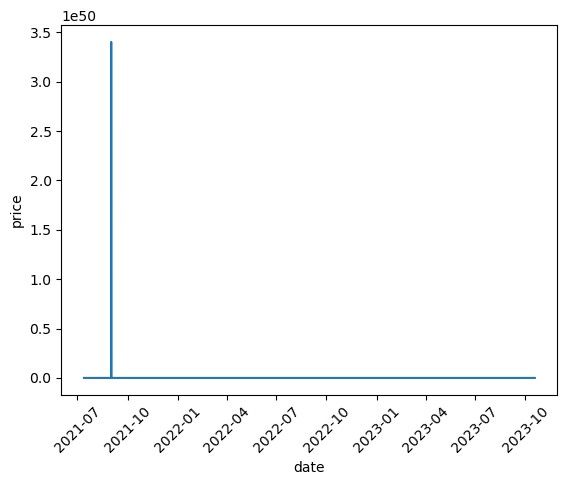

In [4]:
plt.plot(df_arb_3000.index.values,df_arb_3000['price'].values)
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

In [5]:
df_arb_3000[df_arb_3000['price']>10**4]

,blockNumber,price,WETH,USDC,liquidity
datetime,,,,,
2021-08-31 21:56:27,228378,3.402568e+50,-0.26296,841.003815,0


In [4]:
#drop the flawed data points whose price is greater than 10**5 (from the raw data, such cases have zero liquidity) 
df_arb_3000.drop( df_arb_3000[ df_arb_3000['price']>10**5 ].index , inplace=True ) 

#### Repeated datetime

If we show the dataframe, we can see that the datetimes are repeated sometimes. This is due to the fact that trade may come in the same time interval, or even the same block time (the the block time of Arbitrium is 0.25s). 

#### The type of price(not certain)
Note that the price is the one after the trade and is in the sense of closing price. For example, if there are 3 trades that happend at time $t_1, t_2$ and $t_3$ in an one-second interval $[t,t+1)$. The prices after trades are $p_1, p_2$ and $p_3$ respectively. Then there will be three data points that are at time $t$ and with the price $p_1, p_2$ and $p_3$ respectively.
This might be seen directly from the type of trades,the direction of price change( sell WETH, price goes up, vice versa) and partial historical data on oku. 

#### Liquidity dtype
The liquidity is too large (not sure what unit it is in raw data) so that pandas reads it as str.

In [5]:
df_arb_3000['liquidity']=df_arb_3000['liquidity'].astype(float)

#### Early data points
Before 2021-09-01, the frequency of trading is very low. This may be because the pool is just started. So we ignore those data points. 

In [6]:
df_arb_3000 = df_arb_3000[df_arb_3000.index> '2021-09-01'] #discard first few data points 

#### Trades with no price impact/reserves change 

Even though the dataframe ```df_arb_3000``` stores the info of price everytime after a trade occurs in the pool, the below shows that sometime the trade has no impact to the price. The raw data shows that the variable **sqrtPriceX96** does change, but after transformed into pool price the difference is ignored by the computer. 
We also see that the amount of tokens traded in this case is zero (the amount of another token in the trade is extremely small).

In [7]:
# data points where trades have no price impact.
test =df_arb_3000[['price']]-df_arb_3000[['price']].shift(1)
bad_price_diff = test[test['price']==0]
bad_price_diff

,price
datetime,
2022-04-05 18:36:04,0.0
2022-04-05 18:36:19,0.0
2022-05-02 05:33:33,0.0
2022-06-18 07:22:43,0.0
2022-06-21 08:24:00,0.0
...,...
2023-08-25 10:22:06,0.0
2023-08-25 10:22:08,0.0
2023-08-25 10:22:10,0.0


We can see that the data points with no price impact is the subset of those with zero volume. We'll just ignore them.

In [8]:
#data points where the aamounts of one of token in trades are zero 
bad_volume = df_arb_3000[  (df_arb_3000['WETH']==0) | (df_arb_3000['USDC']==0) ]
np.setdiff1d(bad_price_diff, bad_volume )

array([], dtype=float64)

In [9]:
df_arb_3000 = df_arb_3000[ ~ ( (df_arb_3000['WETH']==0) | (df_arb_3000['USDC']==0) )]

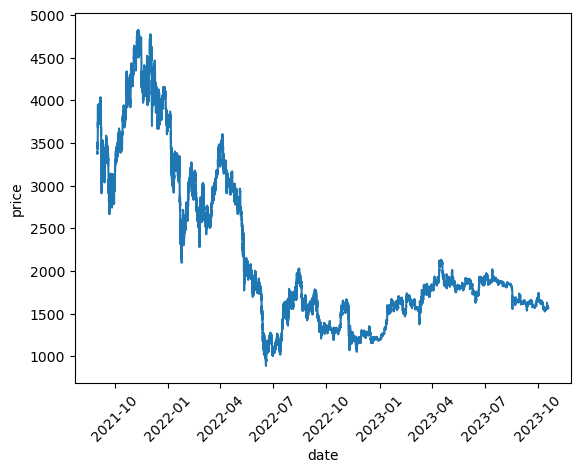

In [10]:
#plot again
plt.plot(df_arb_3000.index.values,df_arb_3000['price'].values)
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

#### Output to csv

In [20]:
df_arb_3000.to_csv(f'Data/organized data/{token_0}_{token_1}_arb_3000/{token_0}_{token_1}_arb_3000_original.csv') 

### Resampling
Now we deal with the time-duplicated data. We only keep the last data point of those with the same arrival time and discard others. The price is set to be the price after the last trade and the amount of traded token is the sum of those of data points with duplicated time. Also we add another column ```No.``` as the relative indices of time-duplicated data points. This can help us to keep track of the number of trades in that period.  


Note that the trade is "path-dependent" when there's trading fee, so one can not get the same price by directly using the data of volume and trading mechanism. 

Parameters:

* ```df```: The original dataframe we want to modify.
* ```T```: Timedelta string that corresponds to the time interval for resample.

Functions:

* ```order```: Add a new column to the input dataframe. The values index the duplicated data points by their relative order of coming in to the pool.

* ```resemple```: Resample the input dataframe w.r.t the given interval. The ouput dataframe has 5 columns **'open','close'**, `token_0`, `token_1`, **"No."**. Given arbitrary time interval $[ kT , (k+1)T  )$, their values are

    1. **'open'** is the close on $[ (k-1)T , kT  )$ (NaN if k=0)
    2. **'close'** is the last price of  $[ kT , (k+1)T  )$ in the original dataframe (before resampling)
    3. `token_0` and `token_1` are the sum of volumes in  $[ (k-1)T , kT  )$ 
    4. **'No.'** is the sum of numbers of trades in  $[ kT , (k+1)T  )$ .

In [35]:
def order(df):
    if 'No.' not in df.columns:
        df['No.']= df.groupby(df.index).cumcount() + 1 
        
def resample(df,T):
    volume_res = df[[ token_0 , token_1 ]].resample(T).sum()  #trading volumns(net reserves change) in one unit of T  
    
    #new df by dropping duplicated,keeping the last trade  
    df_res=df[~df.index.duplicated(keep='last')]
    datetime_ini = df_res.index.values[0]
    
    #resampling price, volume and order repectively then concat
    price_res = df_res['price'].resample(T).last().ffill()
    
    No_res = df_res['No.'].resample(T).sum()  
    df_res= pd.concat([price_res, volume_res, No_res ],axis=1)

    #df_res=df_res.reset_index()
    df_res.rename(columns={'price':'close'},inplace = True)
    df_res['open']= df_res['close'].shift(1)
    df_res = df_res[['open', 'close',  token_0 , token_1 ,'No.'] ]
    return df_res

#### Check the correctness (can ignore this part)
We need to check the function work as expected.
Choose those datapoints that are on the hour. So we can check the sampling interval is indeed left closed right open

In [13]:
# df_arb_3000 = pd.read_csv('Data/organized data/WETH_USDC_arb_3000/WETH_USDC_arb_3000_original.csv', index_col='datetime')
# df_arb_3000.index=pd.to_datetime(df_arb_3000.index)

In [22]:
order(df_arb_3000)
res_arb_3000_1hr = resample(df_arb_3000,"1H")

In [23]:
df_arb_3000[ (df_arb_3000.index.minute ==0) & (df_arb_3000.index.second ==0 ) ]

,blockNumber,price,WETH,USDC,liquidity,No.
datetime,,,,,,
2021-09-12 00:00:00,460475,3233.239014,1.000000,-3224.551360,1.806240e+17,1
2021-09-12 00:00:00,460515,3235.263459,-0.994010,3224.551360,1.806240e+17,2
2021-09-12 00:00:00,460519,3239.967228,-2.305970,7488.306407,1.806240e+17,3
2021-09-12 00:00:00,460536,3238.135676,0.900000,-2906.400751,1.806240e+17,4
2021-09-13 06:00:00,691950,3192.252552,-0.320693,1026.777779,5.354562e+17,1
...,...,...,...,...,...,...
2023-08-03 16:00:00,117787890,1843.876367,2.668634,-4906.460250,9.479304e+17,1
2023-08-06 16:00:00,118767673,1829.607175,-0.001420,2.605088,9.258473e+17,1
2023-08-09 18:00:00,119779535,1851.399549,0.001802,-3.326176,9.513045e+17,1


Consider the data poins roughly in the range '2022-05-11 21:00:00' ~ '2022-05-11 21:59:59' and check the resampled result at the time
'2022-05-11 21:00:00'. We expected the open price to be 2167.968372 (from the time ' 20:59:02') and close price to be 2325.594443 (from the time '21:58:07'). Also, volumes and the number of trades should not include the values at '2022-05-11 22:00:00'.  

In [24]:
df_arb_3000[ (df_arb_3000.index>='2022-05-11 20:59') & (df_arb_3000.index <= '2022-05-11 22:00:00')]

,blockNumber,price,WETH,USDC,liquidity,No.
datetime,,,,,,
2022-05-11 20:59:09,11833029,2035.969446,-5.003671,10195.251000,1.012944e+17,1
2022-05-11 21:00:31,11833114,2034.753942,0.672442,-1364.556285,1.012944e+17,1
2022-05-11 21:01:40,11833244,2040.207459,-3.003257,6137.485634,1.012944e+17,1
2022-05-11 21:01:40,11833270,2049.315134,-4.998842,10252.182600,1.015734e+17,2
2022-05-11 21:02:00,11833377,2058.478516,-5.000128,10300.624400,1.015991e+17,1
...,...,...,...,...,...,...
2022-05-11 21:54:57,11837881,2086.519245,4.447345,-9268.148421,1.136526e+17,1
2022-05-11 21:55:38,11837967,2088.685092,-1.290344,2701.829950,1.136526e+17,1
2022-05-11 21:56:49,11838036,2086.342385,1.400000,-2913.751217,1.136526e+17,1


In [25]:
# trading volumes in the range '2022-05-11 21:00:00' ~ '2022-05-11 21:59:59'
test =df_arb_3000[(df_arb_3000.index>='2022-05-11 21:00') & (df_arb_3000.index < '2022-05-11 22:00:00')]
test[ [token_0 , token_1] ].sum()

WETH      -27.828200
USDC    58483.684541
dtype: float64

In [26]:
# number of trades in the range '2022-05-11 21:00:00' ~ '2022-05-11 21:59:59'
test= df_arb_3000[~df_arb_3000.index.duplicated(keep='last')]
test[(test.index>='2022-05-11 21:00') & (test.index < '2022-05-11 22:00:00')]['No.'].sum()

62

In [27]:
# match!
res_arb_3000_1hr[ res_arb_3000_1hr.index== '2022-05-11 21:00:00' ]

,open,close,WETH,USDC,No.
datetime,,,,,
2022-05-11 21:00:00,2035.969446,2088.285311,-27.8282,58483.684541,62


#### Output to csv

In [16]:
time_list = ['1min', '5min','10min','30min','1H','6H','12H','1D','1W']
order(df_arb_3000)
for T in time_list:
    df_res=  resample(df_arb_3000,T)
    df_res.to_csv(f'Data/organized data/{token_0}_{token_1}_arb_3000/{token_0}_{token_1}_arb_3000_{T}.csv') 

### Arrival

In [36]:
def arrival(df):
    order(df)
    arrival_df = df[["No."]]
    arrival_df = arrival_df[~arrival_df.index.duplicated(keep='last')] 
    arrival_df = arrival_df.reset_index()
    #record the time intervals between orders
    datetime_ini = df.index.values[0]
    arrival_df['interval']= (arrival_df['datetime'] - arrival_df['datetime'].shift(1)).dt.total_seconds()
    return arrival_df

In [37]:
df_arb_3000 = pd.read_csv(f'Data/organized data/WETH_USDC_arb_3000/{token_0}_{token_1}_arb_3000_original.csv',index_col='datetime') 
df_arb_3000.index = pd.to_datetime(df_arb_3000.index)
arrival_3000 =arrival(df_arb_3000)
arrival_3000

,datetime,No.,interval
0,2021-09-01 00:00:46,1,NaN
1,2021-09-01 00:12:50,1,724.0
2,2021-09-01 00:19:28,1,398.0
3,2021-09-01 01:09:55,1,3027.0
4,2021-09-01 02:12:08,1,3733.0
...,...,...,...
297256,2023-10-18 15:13:06,1,30.0
297257,2023-10-18 15:50:02,1,2216.0
297258,2023-10-18 15:56:34,2,392.0
297259,2023-10-18 16:20:24,1,1430.0


In [109]:
arrival_df.to_csv('Data/WETH_USDC_arb_3000_arrival_1sec.csv') 

#### Try to fit Poisson and exponential dist(log linear?)

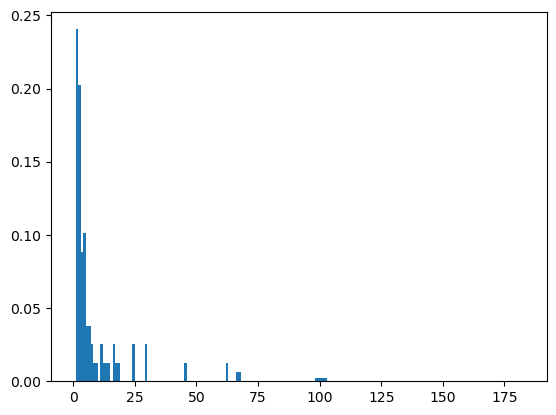

In [110]:
Total_sec = (arrival_df.iloc[-1,0] - arrival_df.iloc[0,0]).total_seconds()
num_0 = Total_sec - len(arrival_df) +1 #number of one-sec interval that has no trade

b =np.unique(arrival_df['No.'].values)
hist = np.histogram(arrival_df['No.'].values , bins = b)[0]

b = np.append(0 , b)
hist = np.append(num_0 , hist)


plt.hist(hist,bins =b , density = True); # empirical distribution of arrival in one sec

In [82]:
arrival_df[arrival_df['order']>100] #2021/9/17 numbers of trades is large! why?

,datetime,order,interval
5399,2021-09-17 15:39:41,131,16.0
5411,2021-09-17 15:49:48,111,42.0
5415,2021-09-17 15:52:20,103,13.0
5421,2021-09-17 15:56:54,118,37.0
5431,2021-09-17 16:04:18,183,3.0
7982,2021-09-22 20:25:11,116,4.0


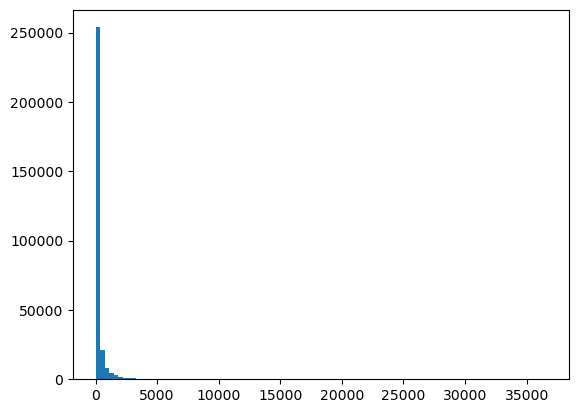

In [43]:
plt.hist(arrival_df['interval'].values,bins=100);

## WETH vs USDC Arbitrium 0.05%

In [8]:
#using WETH vs USDC
token_0 ='WETH'
token_1 ='USDC'

path ="Data/Arbitrum/WETH_USDC_arbitrum_3000"
path2 = "Data/Arbitrum/WETH_USDC_arbitrum_500"
with open(path + "_config.json", 'r') as f:
    TransformData.config = json.load(f)
df_arb_500 = TransformData.main(path2, token_0,token_1)

C:\Users\std92\OneDrive\文件\AMM\other's notes and codes\token_style\TransformData.py:52: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + ".csv", index_col=0)


### A first look at data
Before processing the data, we need to check the data first and pick out those defected data ponits. Sometimes the
values may be too big or too small and they lead to some unexpected problems.

In [9]:
df_arb_500.head()

,blockNumber,price,WETH,USDC,liquidity
datetime,,,,,
2021-08-31 14:15:16,227484,1602.691065,0.010000,-18.001595,3632971980651
2021-08-31 22:07:06,228417,2024.232403,-0.010000,18.020728,3632971980651
2021-08-31 23:39:43,228739,2024.419128,-0.004937,10.000000,4816711909698018
2021-08-31 23:41:48,228740,2025.352882,-0.024680,50.000000,4816711909698018
2021-08-31 23:44:32,228753,3526.784880,-0.036069,75.000000,919807797226


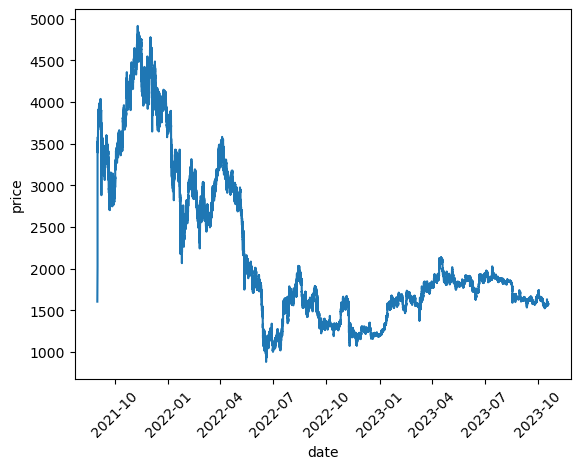

In [10]:
plt.plot(df_arb_500.index.values,df_arb_500['price'].values)
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

#### Liquidity dtype

In [43]:
df_arb_500['liquidity']=df_arb_500['liquidity'].astype(float)

#### Early data points

In [11]:
df_arb_500 = df_arb_500[df_arb_500.index> '2021-09-01']

#### Trades with no price impact/reserves change 

In [13]:
# data points where trades have no price impact.
test =df_arb_500[['price']]-df_arb_500[['price']].shift(1)
bad_price_diff = test[test['price']==0]
bad_price_diff

,price
datetime,
2021-11-11 09:22:51,0.0
2021-11-16 16:04:07,0.0
2021-11-16 16:05:01,0.0
2021-11-16 16:58:34,0.0
2021-11-17 12:34:54,0.0
...,...
2023-09-25 14:00:38,0.0
2023-10-03 15:48:29,0.0
2023-10-04 14:36:34,0.0


In [15]:
#data points where the aamounts of one of token in trades are zero 
bad_volume = df_arb_500[  (df_arb_500['WETH']==0) | (df_arb_500['USDC']==0) ]

In [16]:
df_arb_500 = df_arb_500[ ~ ( (df_arb_500['WETH']==0) | (df_arb_500['USDC']==0) )]

#### Output to csv

In [18]:
df_arb_500.to_csv(f'Data/organized data/WETH_USDC_arb_500/{token_0}_{token_1}_arb_500_original.csv') 

### Resampling

#### Check the correctness(can ignore this part)

In [18]:
# df_arb_500 = pd.read_csv(f'Data/organized data/WETH_USDC_arb_500/{token_0}_{token_1}_arb_500_original.csv',index_col='datetime')
# df_arb_500.index=pd.to_datetime(df_arb_500.index)
# order(df_arb_500)

In [15]:
res_arb_500_30min  =resample(df_arb_500,'30min')

In [317]:
df_arb_500[ (df_arb_500.index.minute ==30) & (df_arb_500.index.second ==0 ) ]

,blockNumber,price,WETH,USDC,liquidity,No.
datetime,,,,,,
2021-09-01 14:30:00,234180,3449.141636,0.001450,-5.000000,9.523267e+14,1
2021-09-18 11:30:00,1180220,3392.849566,-3.281449,11108.225386,8.466080e+16,1
2021-09-18 14:30:00,1187868,3443.618831,0.031000,-106.701649,6.826676e+16,1
2021-09-19 20:30:00,1281293,3298.927598,-0.002121,7.000000,6.181990e+16,1
2021-09-19 20:30:00,1281316,3299.116457,-0.030022,99.092539,6.024311e+16,2
...,...,...,...,...,...,...
2023-10-13 08:30:00,140114690,1543.133463,-1.905816,2942.360000,5.604045e+18,2
2023-10-13 08:30:00,140114692,1543.176732,-2.000000,3087.854123,5.604045e+18,3
2023-10-13 21:30:00,140276647,1551.129110,0.126661,-196.368782,1.204607e+19,1


In [326]:
df_arb_500[ (df_arb_500.index>='2023-06-13 19:59:18') & (df_arb_500.index < '2023-06-13 20:30:00')]

,blockNumber,price,WETH,USDC,liquidity,No.
datetime,,,,,,
2023-06-13 19:59:18,100731182,1753.501671,-0.011577,20.311280,7.358753e+18,1
2023-06-13 20:00:08,100731380,1753.504089,-0.121191,212.614207,7.358753e+18,1
2023-06-13 20:00:12,100731394,1753.504031,0.002921,-5.120000,7.358753e+18,1
2023-06-13 20:00:14,100731402,1753.507444,-0.171000,300.000000,7.358753e+18,1
2023-06-13 20:00:18,100731419,1753.507716,-0.013640,23.929216,7.358753e+18,1
...,...,...,...,...,...,...
2023-06-13 20:29:57,100738562,1753.266323,0.879465,-1541.173047,7.258465e+18,2
2023-06-13 20:29:57,100738562,1753.284105,-2.399585,4209.200000,7.258465e+18,3
2023-06-13 20:29:57,100738561,1753.367569,-18.000000,31573.125900,7.258465e+18,4


In [331]:
# trading volumes in the range '2022-05-11 21:00:00' ~ '2022-05-11 21:59:59'
test =df_arb_500[(df_arb_500.index>='2023-06-13 20:00:00') & (df_arb_500.index < '2023-06-13 20:30:00')]
test[ [token_0 , token_1] ].sum()

WETH      -51.033148
USDC    90893.150215
dtype: float64

In [332]:
# number of trades in the range '2022-05-11 21:00:00' ~ '2022-05-11 21:59:59'
test= df_arb_500[~df_arb_500.index.duplicated(keep='last')]
test[(test.index>='2023-06-13 20:00:00') & (test.index < '2023-06-13 20:30:00')]['No.'].sum()

416

In [ ]:
# match!
res_arb_500_30min[ res_arb_500_30min.index== '2023-06-13 20:00:00']

#### Output to csv

In [21]:
time_list = ['1min', '5min','10min','30min','1H','6H','12H','1D','1W']
order(df_arb_500)
for T in time_list:
    df_res=  resample(df_arb_500,T)
    df_res.to_csv(f'Data/organized data/WETH_USDC_arb_500/{token_0}_{token_1}_arb_500_{T}.csv') 

### Arrival

Number of trades

In [50]:
token_0 ='WETH'
token_1 ='USDC'
df_arb_500 = pd.read_csv(f'Data/organized data/WETH_USDC_arb_500/{token_0}_{token_1}_arb_500_original.csv',index_col='datetime') 
df_arb_500.index = pd.to_datetime(df_arb_500.index)

C:\Users\std92\AppData\Local\Temp\ipykernel_15568\1882988677.py:3: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df_arb_500 = pd.read_csv(f'Data/organized data/WETH_USDC_arb_500/{token_0}_{token_1}_arb_500_original.csv',index_col='datetime')


In [51]:
arrival_500 = arrival(df_arb_500)
#USDC
arrival_500['No.'].sum(),arrival_3000['No.'].sum(), arrival_3000['interval'].mean(),arrival_500['interval'].mean()

(6711932, 398196, 226.0364899414654, 15.90259482663127)

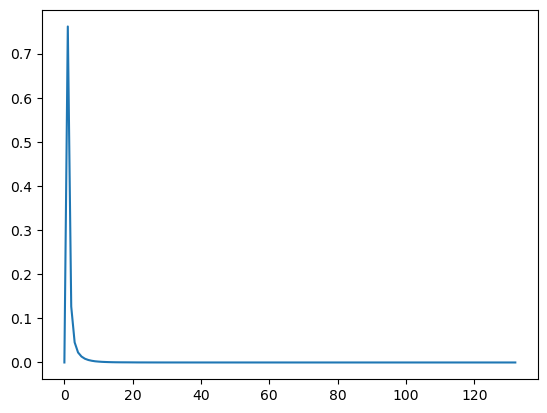

In [49]:
Total_sec = (arrival_df_500.iloc[-1,0] - arrival_df_500.iloc[0,0]).total_seconds()
num_0 = Total_sec - len(arrival_df_500) +1 #number of  intervals that have no trade

b =np.unique(arrival_df_500['No.'].values)
b = np.insert(b ,0, 0)
b= np.insert(b , len(b) , max(b))
hist = np.histogram(arrival_df_500['No.'].values , bins = b ,density = True)[0]

plt.plot(b[:-1],hist)

The arrival time is shorter compared with 0.3% fee case

In [30]:
time_interval_500 = arrival_df_500['interval'].values[1:]

In [42]:
time_interval_500

array([2.831e+04, 5.557e+03, 1.250e+02, ..., 1.300e+01, 5.400e+01,
       3.200e+01])

(0.0, 300.0)

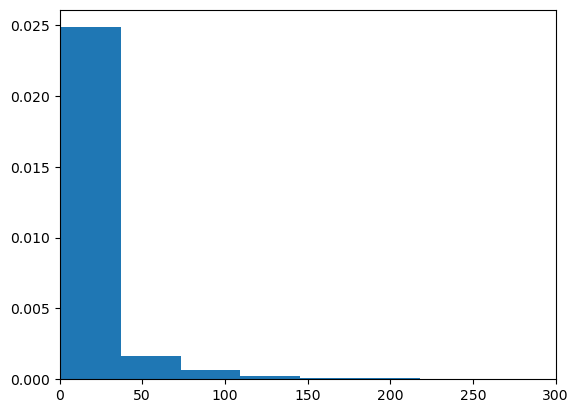

In [103]:
prob,b =np.histogram(time_interval_500,density=True)
plt.plot(b,bp.log(prob))

In [117]:
np.mean(arrival_df2['interval'][-5000:]) , np.std(arrival_df2['interval'])

(25.961, 53.729500339753315)

## WETH vs USDT 0.05% Arbitrium

In [56]:
#using WETH vs USDC
token_0 ='WETH'
token_1 ='USDT'
path0 = "Data/Arbitrum/WETH_USDC_arbitrum_3000"

path = "Data/Arbitrum/WETH_USDT_arbitrum_500"
with open(path0 + "_config.json", 'r') as f:
    TransformData.config = json.load(f)
df_arb_500 = TransformData.main(path,token_0,token_1)

C:\Users\std92\OneDrive\文件\AMM\other's notes and codes\token_style\TransformData.py:52: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + ".csv", index_col=0)


### A first look at data

#### Anomalously high price

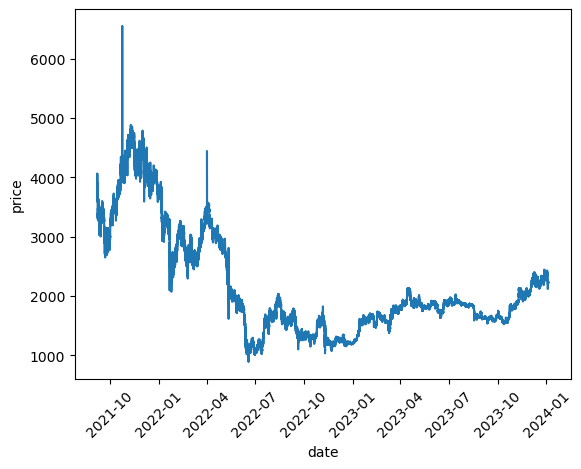

In [57]:
plt.plot(df_arb_500.index.values,df_arb_500['price'].values)
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

Some price too high??

In [58]:
df_arb_500[df_arb_500.index >'2021-10-24 01' ].head(5)

,blockNumber,price,WETH,USDT,liquidity
datetime,,,,,
2021-10-24 01:00:27,2484096,4148.726019,0.300000,-1244.354463,66950074488675404
2021-10-24 01:10:24,2484201,6553.984667,-45.163641,200000.000000,1103537214114283
2021-10-24 01:10:24,2484202,4442.316044,14.464900,-68410.065648,49312341298035154
2021-10-24 01:10:24,2484203,4147.455734,30.880579,-132150.168619,66950074488675404
2021-10-24 01:18:03,2484312,4146.419169,0.130000,-538.832313,66950074488675404


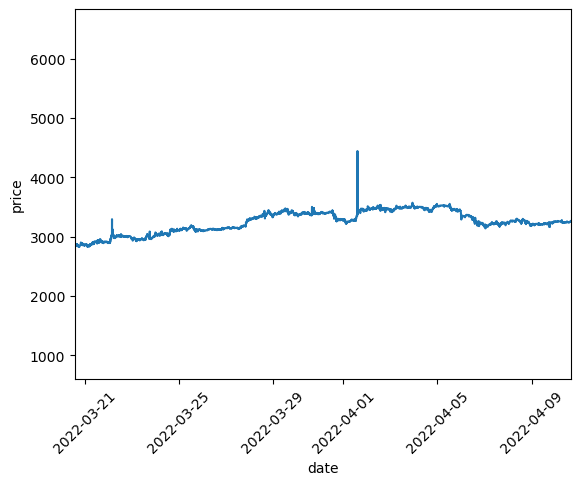

In [59]:
plt.plot(df_arb_500.index.values,df_arb_500['price'].values)
plt.xlabel("date")
plt.ylabel("price")
plt.xlim(datetime(2022,3,20,14,0,0),datetime(2022,4,10,16,0,0))
plt.xticks(rotation=45);

Here we just drop them( or leave them since two points won't affect the analysis)

In [60]:
test=df_arb_500[df_arb_500.index >'2022-4-1 14:14'].head(10)
test

,blockNumber,price,WETH,USDT,liquidity
datetime,,,,,
2022-04-01 14:14:49,9036889,3385.729992,0.000296,-1.000200,40220797983805915
2022-04-01 14:14:49,9036884,3385.732886,-0.295332,1000.000000,40220797983805915
2022-04-01 14:14:57,9036911,3390.595487,-0.498971,1691.443380,40652393692533294
2022-04-01 14:14:57,9036946,3381.093922,1.000000,-3384.073940,50033280322388606
2022-04-01 14:20:11,9037230,3373.123010,1.000000,-3375.426176,50879494168012937
2022-04-01 14:22:53,9037364,4444.399695,-28.649072,102298.623301,11579374271257572
2022-04-01 14:22:53,9037365,3446.924247,20.652782,-74941.547309,38947856127822794
2022-04-01 14:23:45,9037397,3380.208604,1.021650,-3456.363404,50033280322388606
2022-04-01 14:26:26,9037553,3380.183040,0.003256,-11.000000,50033280322388606


In [61]:
df_arb_500 = df_arb_500[(df_arb_500.index !='2021-10-24 01:10:24') & (df_arb_500.index !='2022-04-01 14:22:53') ]

#### Liquidity dtype

In [62]:
df_arb_500['liquidity']=df_arb_500['liquidity'].astype(float)

#### Early data points
Before 2021-09-01, the frequency of trading is very low. This may be because the pool is just started. So we ignore those data points. 

In [63]:
df_arb_500 = df_arb_500[df_arb_500.index> '2021-09-01'] #discard first few data points 

#### Trades with no price impact/reserves change 

In [64]:
# data points where trades have no price impact.
test =df_arb_500[['price']]-df_arb_500[['price']].shift(1)
bad_price_diff = test[test['price']==0]

We can see that the data points with no price impact is the subset of those with zero volume. We'll just ignore them.

In [93]:
#data points where the aamounts of one of token in trades are zero 
bad_volume = df_arb_500[  (df_arb_500['WETH']==0) | (df_arb_500['USDT']==0) ]

#### Output to csv

In [65]:
df_arb_500 = df_arb_500[ ~ ( (df_arb_500['WETH']==0) | (df_arb_500['USDT']==0) )]

In [66]:
df_arb_500.to_csv(f'Data/organized data/{token_0}_{token_1}_arb_500/{token_0}_{token_1}_arb_500_original.csv') 

### Resample

In [97]:
time_list = ['1min', '5min','10min','30min','1H','6H','12H','1D','1W']
order(df_arb_500)
for T in time_list:
    df_res=  resample(df_arb_500,T)
    df_res.to_csv(f'Data/organized data/{token_0}_{token_1}_arb_500/{token_0}_{token_1}_arb_500_{T}.csv') 

### Arrival

In [67]:
token_0 ='WETH'
token_1 ='USDT'
df_arb_USDT_500 = pd.read_csv(f'Data/organized data/{token_0}_{token_1}_arb_500/{token_0}_{token_1}_arb_500_original.csv',index_col='datetime') 
df_arb_USDT_500.index = pd.to_datetime(df_arb_USDT_500.index)

In [68]:
arrival_USDT_500 = arrival(df_arb_USDT_500)
#USDC
arrival_USDT_500['No.'].sum(),arrival_3000['No.'].sum(), arrival_3000['interval'].mean(),arrival_USDT_500['interval'].mean()

(3310076, 398196, 226.0364899414654, 25.974593485142304)

In [69]:
arrival_500['No.'].sum(),arrival_500['interval'].mean()

(6711932, 15.90259482663127)

## WETH vs DAI 0.3% Arbitrium

In [146]:
#using WETH vs USDC
token_0 ='WETH'
token_1 ='DAI'

path = "Data/Arbitrum/WETH_DAI_arbitrum_3000"
with open(path + "_config.json", 'r') as f:
    TransformData.config = json.load(f)
df_arb_3000 = TransformData.main(path,token_0,token_1)

C:\Users\std92\OneDrive\文件\AMM\other's notes and codes\token_style\TransformData.py:52: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + ".csv", index_col=0)


### A first look at data
Not sure that the volume is correct or not, but price seems to be fine.

In [151]:
df_arb_3000.head() 

,blockNumber,price,WETH,DAI,liquidity
datetime,,,,,
2021-09-23 10:45:32,1505367,3110.864249,0.00200,-6.216233,52493529746830347442
2021-09-23 10:55:00,1505747,3078.170016,0.00500,-15.425953,52493529746830347442
2021-09-23 12:48:13,1512382,3110.765908,-0.00497,15.425953,52493529746830347442
2021-09-23 12:51:28,1512514,3097.627648,0.00200,-6.189268,52493529746830347442
2021-09-23 14:16:53,1516209,3096.972869,0.00010,-0.308801,52493529746830347442


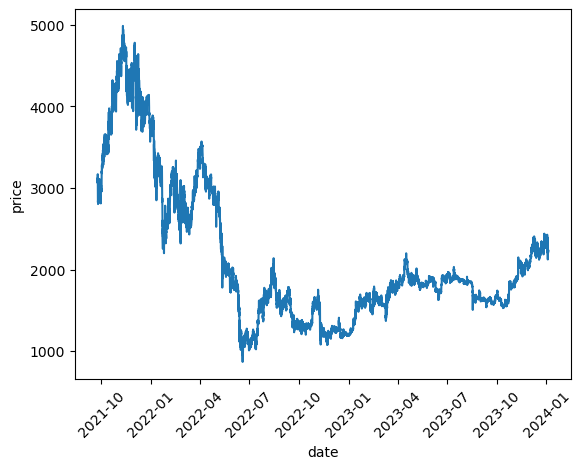

In [145]:
plt.plot(df_arb_3000.index.values,df_arb_3000['price'].values)
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

#### Repeated datetime

If we show the dataframe, we can see that the datetimes are repeated sometimes. This is due to the fact that trade may come in the same time interval, or even the same block time (the the block time of Arbitrium is 0.25s). 

#### The type of price(not certain)
Note that the price is the one after the trade and is in the sense of closing price. For example, if there are 3 trades that happend at time $t_1, t_2$ and $t_3$ in an one-second interval $[t,t+1)$. The prices after trades are $p_1, p_2$ and $p_3$ respectively. Then there will be three data points that are at time $t$ and with the price $p_1, p_2$ and $p_3$ respectively.
This might be seen directly from the type of trades,the direction of price change( sell WETH, price goes up, vice versa) and partial historical data on oku. 

#### Liquidity dtype
The liquidity is too large (not sure what unit it is in raw data) so that pandas reads it as str.

In [153]:
df_arb_3000['liquidity']=df_arb_3000['liquidity'].astype(float)

#### Early data points
Before 2021-09-01, the frequency of trading is very low. This may be because the pool is just started. So we ignore those data points. 

In [154]:
df_arb_3000 = df_arb_3000[df_arb_3000.index> '2021-09-01'] #discard first few data points 

#### Trades with no price impact/reserves change 

Even though the dataframe ```df_arb_3000``` stores the info of price everytime after a trade occurs in the pool, the below shows that sometime the trade has no impact to the price. The raw data shows that the variable **sqrtPriceX96** does change, but after transformed into pool price the difference is ignored by the computer. 
We also see that the amount of tokens traded in this case is zero (the amount of another token in the trade is extremely small).

In [159]:
# data points where trades have no price impact.
test =df_arb_3000[['price']]-df_arb_3000[['price']].shift(1)
bad_price_diff = test[test['price']==0]
bad_price_diff

,price
datetime,
2021-11-30 11:31:21,0.0
2021-11-30 11:33:43,0.0
2022-04-15 17:46:15,0.0
2022-04-15 18:04:49,0.0
2022-04-15 18:18:11,0.0
2022-04-15 18:19:39,0.0
2022-04-15 18:25:35,0.0
2022-04-29 09:51:51,0.0
2022-09-01 20:07:07,0.0


We can see that the data points with no price impact is the subset of those with zero volume. We'll just ignore them.

In [160]:
#data points where the aamounts of one of token in trades are zero 
bad_volume = df_arb_3000[  (df_arb_3000['WETH']==0) | (df_arb_3000['DAI']==0) ]
bad_volume

,blockNumber,price,WETH,DAI,liquidity
datetime,,,,,
2023-03-21 14:20:46,72145515,1820.402823,1.000000e-18,0.000000e+00,4.161897e+22
2023-04-13 10:33:27,79992578,1987.518532,0.000000e+00,7.300000e-17,4.975296e+22
2023-04-13 11:15:12,80002619,1991.687151,0.000000e+00,1.000000e-18,4.965910e+22
2023-09-12 06:21:38,130327666,1581.128213,0.000000e+00,1.800000e-17,2.782190e+22
2023-09-18 09:58:48,132181243,1636.806413,0.000000e+00,4.000000e-18,2.692321e+22


In [11]:
df_arb_3000 = df_arb_3000[ ~ ( (df_arb_3000['WETH']==0) | (df_arb_3000['USDC']==0) )]

#### Output to csv

In [161]:
df_arb_3000.to_csv(f'Data/organized data/{token_0}_{token_1}_arb_3000/{token_0}_{token_1}_arb_3000_original.csv') 

### Resemple

In [162]:
time_list = ['1min', '5min','10min','30min','1H','6H','12H','1D','1W']
order(df_arb_3000)
for T in time_list:
    df_res=  resample(df_arb_3000,T)
    df_res.to_csv(f'Data/organized data/{token_0}_{token_1}_arb_3000/{token_0}_{token_1}_arb_3000_{T}.csv') 

### Arrival

In [74]:
token_0 ='WETH'
token_1 ='DAI'
df_arb_DAI_3000 = pd.read_csv(f'Data/organized data/{token_0}_{token_1}_arb_3000/{token_0}_{token_1}_arb_3000_original.csv',index_col='datetime') 
df_arb_DAI_3000.index = pd.to_datetime(df_arb_DAI_3000.index)
arrival_DAI_3000 = arrival(df_arb_DAI_3000)


# Mainnet

## WETH vs USDC 0.05% Mainnet

In [14]:
#using WETH vs USDC (now token_0 is USDC!)
token_0 ='USDC'
token_1 ='WETH'

path = "Data/Mainnet/WETH_USDC_mainnet"
with open(path + "_config.json", 'r') as f:
    TransformData.config = json.load(f)
df_m_500 = TransformData.main(path+'_500',token_0,token_1)

### A first look at data

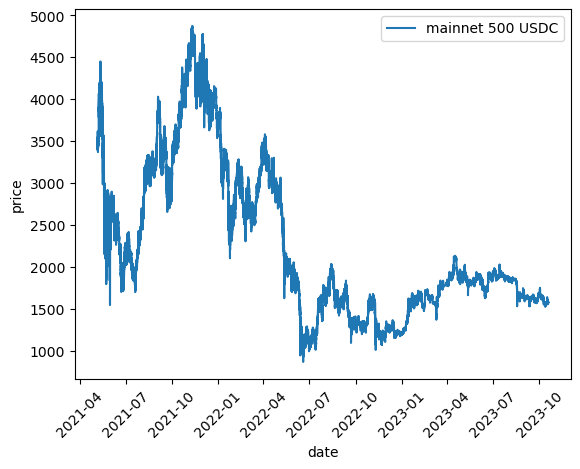

In [20]:
plt.plot(df_m_500.index.values,df_m_500['price'].values , label='mainnet 500 USDC')
plt.legend()
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

#### Liquidity dtype
The liquidity is too large (not sure what unit it is in raw data) so that pandas reads it as str.

In [5]:
df_m_500['liquidity']=df_m_500['liquidity'].astype(float)

#### Early data points
Before 2021-09-01, the frequency of trading is very low. This may be because the pool is just started. So we ignore those data points. 

In [6]:
df_m_500 = df_m_500[df_m_500.index> '2021-09-01'] #discard first few data points 

#### Trades with no price impact/reserves change 

In [7]:
# data points where trades have no price impact.
test =df_m_500[['price']]-df_m_500[['price']].shift(1)
bad_price_diff = test[test['price']==0]
bad_price_diff

,price
datetime,
2021-09-06 08:00:58,0.0
2021-09-07 04:33:04,0.0
2021-09-18 16:46:44,0.0
2021-09-21 23:56:11,0.0
2021-11-12 13:02:09,0.0
...,...
2023-10-11 00:49:11,0.0
2023-10-12 08:18:47,0.0
2023-10-16 19:15:35,0.0


In [8]:
#data points where the aamounts of one of token in trades are zero 
bad_volume = df_m_500[  (df_m_500['WETH']==0) | (df_m_500['USDC']==0) ]
np.setdiff1d(bad_price_diff, bad_volume )

array([], dtype=float64)

In [9]:
df_m_500 = df_m_500[ ~ ( (df_m_500['WETH']==0) | (df_m_500['USDC']==0) )]

#### Output to csv

In [11]:
df_m_500.to_csv(f'Data/organized data/{token_1}_{token_0}_mainnet_500/{token_1}_{token_0}_m_500_original.csv') 

#### Resemple and output to csv

In [21]:
# df_m_500 = pd.read_csv(f'Data/organized data/WETH_USDC_mainnet_500/{token_1}_{token_0}_m_500_original.csv',index_col='datetime')
# df_m_500.index=pd.to_datetime(df_m_500.index)

In [24]:
time_list = ['1min','5min','10min','30min','1H','6H','12H','1D','1W']
order(df_m_500)
for T in time_list:
    df_res=  resample(df_m_500,T)
    df_res.to_csv(f'Data/organized data/{token_1}_{token_0}_mainnet_500/{token_1}_{token_0}_m_500_{T}.csv') 

### Arrival

In [76]:
token_0 ='WETH'
token_1 ='USDC'
df_m_USDC_500 = pd.read_csv(f'Data/organized data/{token_0}_{token_1}_mainnet_500/{token_0}_{token_1}_m_500_original.csv',index_col='datetime') 
df_m_USDC_500.index = pd.to_datetime(df_m_USDC_500.index)
arrival_m_USDC_500 = arrival(df_m_USDC_500)

## WETH vs USDC 0.3% Mainnet

In [100]:
#using WETH vs USDC (now token_0 is USDC!)
token_0 ='USDC'
token_1 ='WETH'

path = "Data/Mainnet/WETH_USDC_mainnet"
with open(path + "_config.json", 'r') as f:
    TransformData.config = json.load(f)
df_m_3000 = TransformData.main(path+'_3000',token_0,token_1)

In [15]:
df_m_3000

,blockNumber,price,USDC,WETH,liquidity
datetime,,,,,
2021-05-05 01:56:23,12371376,3306.001763,-0.329608,1.000000e-04,4303369674465501
2021-05-05 08:23:26,12373132,3301.602222,-164.694492,5.000000e-02,4303369674465501
2021-05-05 09:50:51,12373520,3301.593431,-0.329169,1.000000e-04,4303369674465501
2021-05-05 11:59:57,12374077,3301.593431,0.000002,-3.291690e-13,4304946248093346
2021-05-05 12:56:56,12374320,3343.219561,1559.137299,-4.678809e-01,4304946248093346
...,...,...,...,...,...
2023-10-18 13:53:11,18377659,1575.170298,-143588.212029,9.138098e+01,6536068487952795550
2023-10-18 14:37:47,18377880,1574.159744,-83224.674251,5.301134e+01,6536068487952795550
2023-10-18 15:50:35,18378240,1573.969224,-15693.422876,1.000000e+01,6536068487952795550


### A first look at data

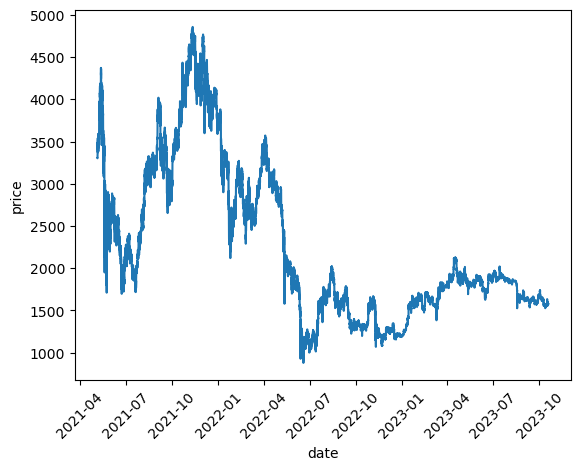

In [101]:
plt.plot(df_m_3000.index.values,df_m_3000['price'].values , label='mainnet 3000')
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

#### Liquidity dtype
The liquidity is too large (not sure what unit it is in raw data) so that pandas reads it as str.

In [20]:
df_m_3000['liquidity']=df_m_3000['liquidity'].astype(float)

#### Early data points
Before 2021-09-01, the frequency of trading is very low. This may be because the pool is just started. So we ignore those data points. 

In [21]:
df_m_3000 = df_m_3000[df_m_3000.index> '2021-09-01'] #discard first few data points 

#### Trades with no price impact/reserves change 

In [22]:
# data points where trades have no price impact.
test =df_m_3000[['price']]-df_m_3000[['price']].shift(1)
bad_price_diff = test[test['price']==0]
bad_price_diff

,price
datetime,
2021-12-08 22:10:48,0.0
2022-03-08 16:05:37,0.0
2022-03-08 16:31:12,0.0
2022-04-05 02:14:56,0.0
2022-04-05 07:39:12,0.0
...,...
2023-06-09 22:23:59,0.0
2023-06-30 06:19:47,0.0
2023-07-21 02:55:23,0.0


In [23]:
#data points where the aamounts of one of token in trades are zero 
bad_volume = df_m_3000[  (df_m_3000['WETH']==0) | (df_m_3000['USDC']==0) ]
np.setdiff1d(bad_price_diff, bad_volume )

array([], dtype=float64)

In [24]:
df_m_3000 = df_m_3000[ ~ ( (df_m_3000['WETH']==0) | (df_m_3000['USDC']==0) )]

#### Output to csv

In [26]:
df_m_3000.to_csv(f'Data/organized data/{token_1}_{token_0}_mainnet_3000/{token_1}_{token_0}_m_3000_original.csv') 

#### Resemple and output to csv

In [26]:
# df_m_3000 = pd.read_csv(f'Data/organized data/WETH_USDC_mainnet_3000/{token_1}_{token_0}_m_3000_original.csv',index_col='datetime')
# df_m_3000.index=pd.to_datetime(df_m_3000.index)

In [27]:
time_list = ['1min','5min','10min','30min','1H','6H','12H','1D','1W']
order(df_m_3000)
for T in time_list:
    df_res=  resample(df_m_3000,T)
    df_res.to_csv(f'Data/organized data/{token_1}_{token_0}_mainnet_3000/{token_1}_{token_0}_m_3000_{T}.csv') 

### Arrival

In [78]:
token_0 ='WETH'
token_1 ='USDC'
df_m_USDC_3000 = pd.read_csv(f'Data/organized data/{token_0}_{token_1}_mainnet_3000/{token_0}_{token_1}_m_3000_original.csv',index_col='datetime') 
df_m_USDC_3000.index = pd.to_datetime(df_m_USDC_3000.index)
arrival_m_USDC_3000 = arrival(df_m_USDC_3000)

## WETH vs USDT 0.05% Mainnet

In [110]:
#using WETH vs USDT
token_0 ='WETH'
token_1 ='USDT'
path0 = "Data/Arbitrum/WETH_USDC_arbitrum_3000"
path = "Data/Mainnet/WETH_USDT_mainnet"
with open(path0 + "_config.json", 'r') as f:
    TransformData.config = json.load(f)
df_m_500 = TransformData.main(path+'_500',token_0,token_1)

C:\Users\std92\OneDrive\文件\AMM\other's notes and codes\token_style\TransformData.py:52: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + ".csv", index_col=0)


### A first look at data
Before processing the data, we need to check the data first and pick out those defected data ponits. Sometimes the
values may be too big or too small and they lead to some unexpected problems.

In [50]:
df_m_500.head(15)

,blockNumber,price,WETH,USDT,liquidity
datetime,,,,,
2021-05-05 22:23:23,12376933,3427.204448,0.122272,-419.805363,3117440114692251
2021-05-05 22:41:21,12377020,3486.777109,-0.433911,1500.722698,2960815357424257
2021-05-05 22:44:00,12377033,3569.760781,-0.586231,2069.273247,2960815357424257
2021-05-05 22:47:31,12377053,3555.404307,0.100000,-356.079402,2960815357424257
2021-05-05 22:47:53,12377055,3551.176421,0.029565,-105.000000,2960815357424257
2021-05-05 22:49:02,12377062,3549.748090,0.010000,-35.486869,2960815357424257
2021-05-05 22:49:53,12377068,3531.966426,0.125000,-442.384459,2960815357424257
2021-05-05 22:52:14,12377080,3485.713908,0.329610,-1155.945276,2960815357424257
2021-05-05 23:00:57,12377122,3505.506801,-0.142897,499.760879,2984192514712684


#### Anomalously high price
Trying to plot the price trajectory. It shows that there's a data point with the price having rougly $10^{50}$ order, which doesn't make sense.

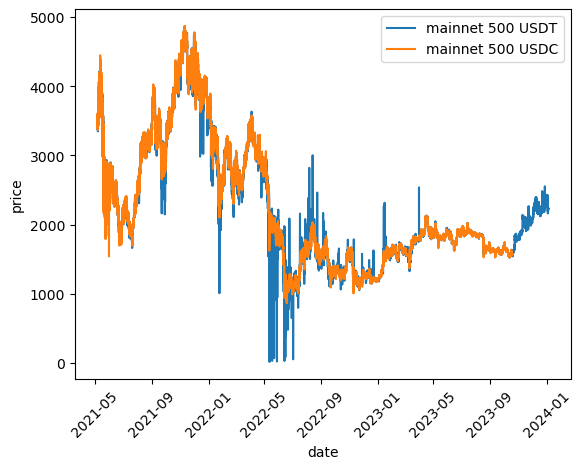

In [112]:
plt.plot(df_m_500.index.values,df_m_500['price'].values,label='mainnet 500 USDT')
plt.plot(df_m_500_2.index.values,df_m_500_2['price'].values , label='mainnet 500 USDC')
plt.legend()
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

## Anomalously low price??? 
2022 5/12 ~ 2022/7/13 ? why? doesn't mathc the results on the price history website!

In [191]:
df_m_500[df_m_500['price']<1000]  

,blockNumber,price,WETH,USDT,liquidity
datetime,,,,,
2022-05-12 12:23:01,14761061,19.273130,383.578565,-4.886526e+05,584670201903544
2022-05-12 12:52:04,14761176,16.223886,16.000000,-2.915757e+02,584670201903544
2022-05-18 07:40:12,14797574,31.181294,1222.881028,-2.167913e+06,584670201903544
2022-05-22 14:56:23,14824009,70.675248,1222.881028,-2.220143e+06,590166714180892
2022-05-27 08:06:27,14853005,906.208107,182.895457,-2.986734e+05,2272975502929994
...,...,...,...,...,...
2022-07-12 02:28:02,15125159,990.176115,1098.848747,-1.147596e+06,81977408086664125
2022-07-12 07:28:53,15126536,971.077787,837.644576,-8.621629e+05,73742083969224972
2022-07-12 19:40:43,15129796,969.078319,506.946288,-5.142706e+05,82798469927779544


In [6]:
#drop the flawed data points whose price is greater than 10**5 (from the raw data, such cases have zero liquidity) 
df_m_500.drop( df_m_500[ df_m_500['price']>10**5 ].index , inplace=True ) 

#### Liquidity dtype

In [7]:
df_m_500['liquidity']=df_m_500['liquidity'].astype(float)

#### Early data points

In [8]:
df_m_500 = df_m_500[df_m_500.index> '2021-09-01'] #discard first few data points 

#### Trades with no price impact/reserves change 

In [9]:
# data points where trades have no price impact.
test =df_m_500[['price']]-df_m_500[['price']].shift(1)
bad_price_diff = test[test['price']==0]
bad_price_diff

,price
datetime,
2022-04-05 18:36:04,0.0
2022-04-05 18:36:19,0.0
2022-05-02 05:33:33,0.0
2022-06-18 07:22:43,0.0
2022-06-21 08:24:00,0.0
...,...
2023-08-25 10:22:06,0.0
2023-08-25 10:22:08,0.0
2023-08-25 10:22:10,0.0


In [10]:
#data points where the aamounts of one of token in trades are zero 
bad_volume = df_m_500[  (df_m_500['WETH']==0) | (df_m_500['USDC']==0) ]
bad_volume

array([], dtype=float64)

In [11]:
df_m_500 = df_m_500[ ~ ( (df_m_500['WETH']==0) | (df_m_500['USDC']==0) )]

#### Output to csv

In [53]:
df_m_500.to_csv(f'Data/organized data/{token_0}_{token_1}_mainnet_500/{token_0}_{token_1}_m_500_original.csv') 

## WETH vs USDT 0.3% Mainnet

In [206]:
#using WETH vs USDT
token_0 ='WETH'
token_1 ='USDT'
path0 = "Data/Arbitrum/WETH_USDC_arbitrum_3000"
path = "Data/Mainnet/WETH_USDT_mainnet_3000"
with open(path0 + "_config.json", 'r') as f:
    TransformData.config = json.load(f)
df_m_3000 = TransformData.main(path,token_0,token_1)

C:\Users\std92\OneDrive\文件\AMM\other's notes and codes\token_style\TransformData.py:52: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + ".csv", index_col=0)


### A first look at data

In [226]:
df_m_3000.head()

,blockNumber,price,WETH,USDT,liquidity,No.
datetime,,,,,,
2021-09-01 00:00:48,13136431,3426.485456,207.489606,-709505.273769,1.267122e+19,1
2021-09-01 00:01:45,13136435,3420.312939,195.798021,-668283.694666,1.266489e+19,1
2021-09-01 00:02:28,13136436,3420.306640,0.200000,-682.009772,1.266489e+19,1
2021-09-01 00:03:21,13136439,3416.096131,133.817990,-456044.502665,1.266489e+19,1
2021-09-01 00:04:48,13136445,3422.957229,-217.292588,745273.291596,1.267122e+19,1


#### Anomalously high price
Trying to plot the price trajectory. It shows that there's a data point with the price having rougly $10^{50}$ order, which doesn't make sense.

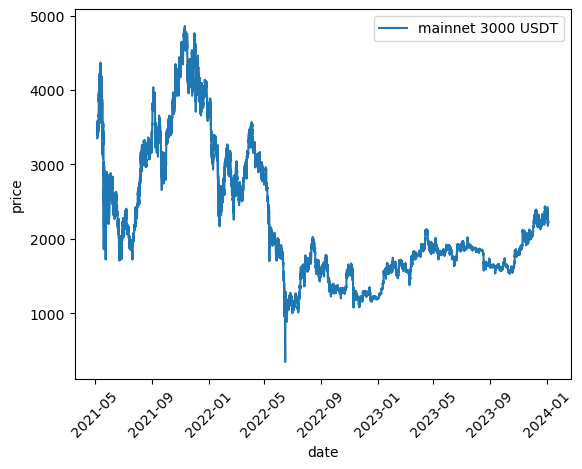

In [209]:
plt.plot(df_m_3000.index.values,df_m_3000['price'].values,label='mainnet 3000 USDT')
plt.legend()
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

In [216]:
df_m_3000[df_m_3000['price']<800]  

,blockNumber,price,WETH,USDT,liquidity
datetime,,,,,
2022-06-15 09:27:45,14966784,345.568762,1291.987966,-1.092907e+06,6162127709923684


In [218]:
#drop the flawed data points whose price is greater than 10**5 (from the raw data, such cases have zero liquidity) 
df_m_3000.drop( df_m_3000[ df_m_3000['price']<800 ].index , inplace=True ) 

#### Liquidity dtype

In [219]:
df_m_3000['liquidity']=df_m_3000['liquidity'].astype(float)

#### Early data points

In [220]:
df_m_3000 = df_m_3000[df_m_3000.index> '2021-09-01'] #discard first few data points 

#### Trades with no price impact/reserves change 

In [221]:
# data points where trades have no price impact.
test =df_m_3000[['price']]-df_m_3000[['price']].shift(1)
bad_price_diff = test[test['price']==0]
bad_price_diff

,price
datetime,
2022-04-07 02:27:00,0.0
2022-04-08 02:28:14,0.0
2022-06-22 23:33:59,0.0
2022-08-03 07:23:07,0.0
2022-08-08 09:12:16,0.0
2022-09-12 13:21:42,0.0
2022-09-12 13:26:01,0.0
2022-09-12 14:44:50,0.0
2023-01-30 05:48:23,0.0


In [222]:
#data points where the aamounts of one of token in trades are zero 
bad_volume = df_m_3000[  (df_m_3000['WETH']==0) | (df_m_3000['USDT']==0) ]
bad_volume

,blockNumber,price,WETH,USDT,liquidity
datetime,,,,,
2021-10-08 11:42:16,13377980,3631.245765,4.890000e-16,0.000000,7.314278e+18
2021-12-03 08:44:34,13732601,4558.738917,2.330000e-16,0.000000,1.136474e+19
2021-12-08 01:44:47,13762011,4325.474401,1.800000e-16,0.000000,1.211364e+19
2022-04-08 02:28:14,14542491,3250.752247,1.000000e-11,0.000000,1.070966e+19
2023-08-15 14:27:35,17920832,1843.888964,4.000000e-18,0.000000,3.797107e+18
2023-08-17 00:52:35,17931086,1789.096507,2.641950e-12,0.000000,4.870222e+18
2023-10-03 06:48:47,18268323,1665.236254,8.100000e-11,0.000000,4.222147e+18
2023-10-06 04:53:23,18289201,1620.298524,5.041680e-13,0.000000,4.190823e+18
2023-10-14 23:21:47,18351868,1556.367431,0.000000e+00,0.000001,4.547460e+18


In [223]:
df_m_3000 = df_m_3000[ ~ ( (df_m_3000['WETH']==0) | (df_m_3000['USDT']==0) )]

#### Output to csv

In [224]:
df_m_3000.to_csv(f'Data/organized data/{token_0}_{token_1}_mainnet_3000/{token_0}_{token_1}_m_3000_original.csv') 

### Resemple and output to csv

In [225]:
time_list = ['1min', '5min','10min','30min','1H','6H','12H','1D','1W']
order(df_m_3000)
for T in time_list:
    df_res=  resample(df_m_3000,T)
    df_res.to_csv(f'Data/organized data/{token_0}_{token_1}_mainnet_3000/{token_0}_{token_1}_m_3000_{T}.csv') 

### Arrival

In [80]:
token_0 ='WETH'
token_1 ='USDT'
df_m_USDT_3000 = pd.read_csv(f'Data/organized data/{token_0}_{token_1}_mainnet_3000/{token_0}_{token_1}_m_3000_original.csv',index_col='datetime') 
df_m_USDT_3000.index = pd.to_datetime(df_m_USDT_3000.index)
arrival_m_USDT_3000 = arrival(df_m_USDT_3000)

## WETH vs DAI 0.3%

In [184]:
#using WETH vs USDC
token_0 ='WETH'
token_1 ='DAI'

path = "Data/Mainnet/WETH_DAI_mainnet_3000"
with open(path + "_config.json", 'r') as f:
    TransformData.config = json.load(f)
df_m_3000 = TransformData.main(path,token_0,token_1)

### A first look at data

In [185]:
df_m_3000.head(10)

,blockNumber,price,WETH,DAI,liquidity
datetime,,,,,
2021-05-04 20:21:15,12369879,3371.050772,-33.854156,1.000000e-02,80059851033970806503
2021-05-04 21:11:21,12370126,3371.050602,-0.000336,1.000000e-07,229713263233648638236
2021-05-05 00:41:36,12371051,3270.498157,-331.043259,1.000000e-01,379427976363351507096
2021-05-05 01:22:32,12371223,3267.476370,-10.026668,3.076439e-03,379427976363351507096
2021-05-05 18:00:03,12375729,3277.845212,10682.019393,-3.254229e+00,117516434432686612962365
2021-05-05 18:02:47,12375737,3375.710052,100000.000000,-2.997218e+01,117516434432686612962365
2021-05-05 18:17:48,12375807,3400.213663,24832.680339,-7.307740e+00,117621635289029330834385
2021-05-05 18:42:13,12375916,3387.985608,-12351.278238,3.650000e+00,117691918578448968991125
2021-05-05 18:43:26,12375925,3387.160398,-840.089983,2.487379e-01,118504767395327940534068


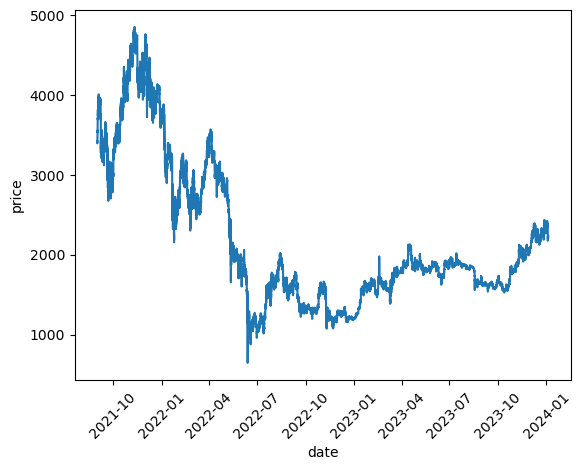

In [192]:
plt.plot(df_m_3000.index.values,df_m_3000['price'].values)
plt.xlabel("date")
plt.ylabel("price")
plt.xticks(rotation=45);

#### Liquidity dtype

In [188]:
df_m_3000['liquidity']=df_m_3000['liquidity'].astype(float)

#### Early data points

In [190]:
df_m_3000 = df_m_3000[df_m_3000.index> '2021-09-01'] #discard first few data points 

#### Trades with no price impact/reserves change 

In [199]:
# data points where trades have no price impact.
test =df_m_3000[['price']]-df_m_3000[['price']].shift(1)
bad_price_diff = test[test['price']==0]
bad_price_diff

,price
datetime,
2022-03-23 01:27:55,0.0
2022-03-26 15:24:23,0.0
2022-03-26 15:51:38,0.0
2022-04-29 03:39:27,0.0
2022-06-12 05:38:46,0.0
2022-07-29 20:46:18,0.0
2022-07-30 08:53:49,0.0
2022-08-04 19:21:11,0.0
2022-08-05 01:33:07,0.0


In [200]:
#data points where the aamounts of one of token in trades are zero 
bad_volume = df_m_3000[  (df_m_3000['WETH']==0) | (df_m_3000['DAI']==0) ]
bad_volume

,blockNumber,price,WETH,DAI,liquidity
datetime,,,,,
2022-03-23 01:27:55,14439626,2942.259277,1.000000e-18,0.000000e+00,1650837695179840867815975
2022-08-09 02:38:16,15305384,1768.235497,0.000000e+00,1.000000e-18,1106636537174050885967742
2022-08-10 05:21:47,15312497,1678.711111,0.000000e+00,1.000000e-18,955417817758499881015661
2022-08-11 13:59:25,15321116,1909.589779,0.000000e+00,1.000000e-18,413854995417652277518497
2022-12-25 22:06:59,16264641,1219.641541,1.000000e-18,0.000000e+00,1740800841557742930349383
2022-12-25 22:08:11,16264647,1219.641541,1.000000e-18,0.000000e+00,1740800841557742930349383


In [201]:
df_m_3000 = df_m_3000[ ~ ( (df_m_3000['WETH']==0) | (df_m_3000['DAI']==0) )]

#### Output to csv

In [202]:
df_m_3000.to_csv(f'Data/organized data/{token_0}_{token_1}_mainnet_3000/{token_0}_{token_1}_m_3000_original.csv') 

### Resample and output to csv

In [205]:
time_list = ['1min', '5min','10min','30min','1H','6H','12H','1D','1W']
order(df_m_3000)
for T in time_list:
    df_res=  resample(df_m_3000,T)
    df_res.to_csv(f'Data/organized data/{token_0}_{token_1}_mainnet_3000/{token_0}_{token_1}_m_3000_{T}.csv') 

C:\Users\std92\AppData\Local\Temp\ipykernel_17892\4048485478.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['No.']= df.groupby(df.index).cumcount() + 1


### Arrival

In [82]:
token_0 ='WETH'
token_1 ='DAI'
df_m_DAI_3000 = pd.read_csv(f'Data/organized data/{token_0}_{token_1}_mainnet_3000/{token_0}_{token_1}_m_3000_original.csv',index_col='datetime') 
df_m_DAI_3000.index = pd.to_datetime(df_m_DAI_3000.index)
arrival_m_DAI_3000 = arrival(df_m_DAI_3000)

#  Price from Binance

## ETH

### Fetch the data and check

We can see that in the data, there are some jumps of datetime(more than one minute). 

In [3]:
token_0 = 'ETH'
token_1 = 'USD'

In [209]:
df_CEX = pd.read_csv("Data/Binance/ETH_USD_Binance.csv")
df_CEX['datetime']=pd.to_datetime(df_CEX['timestamp'])
df_CEX['diff'] = df_CEX['datetime'] - df_CEX['datetime'].shift(1)
df_CEX[ df_CEX['diff']!= '0 days 00:01:00']

,Unnamed: 0,timestamp,close,datetime,diff
0,0,2021-08-31 14:16:00,3413.65,2021-08-31 14:16:00,NaT
41324,41324,2021-09-29 09:00:00,2904.11,2021-09-29 09:00:00,0 days 02:01:00
820584,119981,2023-03-24 14:00:00,1763.69,2023-03-24 14:00:00,0 days 01:21:00


In [210]:
df_CEX= df_CEX[ ['datetime','close'] ]  
df_CEX.set_index( 'datetime',inplace=True)
df_CEX=df_CEX.resample('T').ffill()

In [13]:
tt= df_CEX
tt=tt.reset_index()
tt['diff']=tt['datetime']-tt['datetime'].shift(1)
tt[ tt['diff'] != "0 days 00:01:00"] #indeed no gap for datetime now

,datetime,close,diff
0,2017-08-17 04:00:00,301.13,NaT


#### Add more data
Here we extend the range of time to '2017 8/17 ~ 2023/10/18 '

In [6]:
df_CEX_0 = pd.read_csv('Data/Binance/ETH_2017to2021.csv',index_col='datetime')[['close']]
df_CEX_0.index = pd.to_datetime(df_CEX_0.index)

df_CEX_1 = pd.read_csv('Data/Binance/ETH_USD_1min.csv' ,index_col='datetime')
df_CEX_1.index = pd.to_datetime(df_CEX_1.index)

In [14]:
#df_CEX_1min = pd.concat([df_CEX_0,df_CEX_1])
df_CEX_1min.to_csv('Data/Binance/ETH_USD_1min.csv' )

(18901.0, 19631.0)

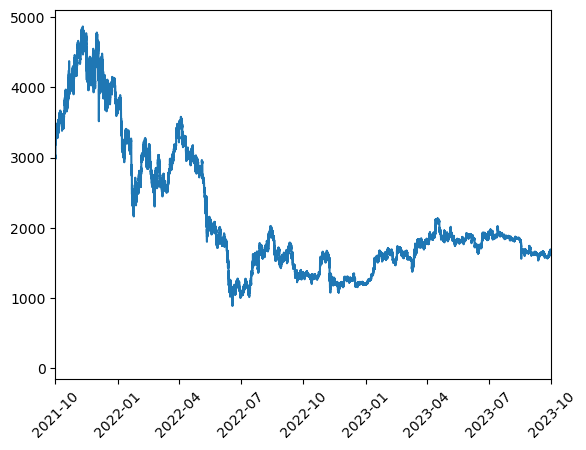

In [13]:
plt.plot(df_CEX.index,df_CEX.close)
plt.xticks(rotation = 45)
plt.xlim(datetime(2021,10,1),datetime(2023,10,1))


### Resample and output to csv
We consider the same intervals as pool resampled data as before. For daily frequency, we will choose different starting/end times in a day (e.g 1pm to 1pm instead of 0am to 0am etc). 

In [11]:
df_CEX = pd.read_csv('Data/Binance/ETH/ETH_USD_1min.csv' ,index_col='datetime')
df_CEX.index = pd.to_datetime(df_CEX.index)

In [ ]:
time_list = ['5min', '10min','30min','1H','6H','12H','1D','1W','1M','1Q' ]
for T in time_list:
    df = df_CEX.resample(T).last()
    path= f'Data/Binance/{token_0}_{token_1}_{T}.csv'
    df.to_csv(path)

In [5]:
df_list = []
for t in range(24):
    time = f'{t}H'
    if t == 0:
        df = df_CEX.resample('1D').last()
    else:
        df = df_CEX.resample('1D',offset=time).last()
    df['start'] = time
    df_list.append(df)
df_CEX_daily =pd.concat(df_list)
df_CEX_daily
df_CEX_daily.to_csv('Data/Binance/ETH_USD_daily.csv')

Also we'll create another daily-frequency dataframe whose timeframe aligns with traditional CEXs. The start time(open) is 9:30 a.m EST/EDT and end time (close): 16:00 p.m EST. We choose the start date to be 2021 9/1 UTC.

In [43]:
copy = df_CEX.copy()

#Change to EST/EDT
copy.index= copy.index.tz_localize('UTC')
copy.index = copy.index.tz_convert('America/New_York')
copy.index= copy.index.tz_localize(None)

df_open0 =copy[ (copy.index.hour ==9) &(copy.index.minute ==30)]
df_open1 = df_open0.reset_index()
df_open1['datetime'] = df_open1['datetime'].apply(lambda x: x.date())
df_open0 = df_open1[ ['datetime' , 'close']]
df_open0.set_index('datetime',inplace=True)
df_open0=df_open0.rename( columns={'close':'open'})


df_close0 = copy[ (copy.index.hour == 16) &(copy.index.minute ==0)]
df_close1 = df_close0.reset_index()
df_close1['datetime'] = df_close1['datetime'].apply(lambda x: x.date())
df_close0 = df_close1[ ['datetime' , 'close']]
df_close0.set_index('datetime',inplace=True)

df_CEX_9to16 = pd.concat([df_open0 ,df_close0] , axis=1) 
df_CEX_9to16
df_CEX_9to16.to_csv('Data/Binance/ETH_USD_9to16.csv' )

,open,close
date,,
2017-08-17,309.52,302.11
2017-08-18,301.30,295.46
2017-08-19,288.04,293.31
2017-08-20,292.28,297.87
2017-08-21,337.06,332.27
...,...,...
2023-10-14,1550.40,1555.23
2023-10-15,1559.48,1559.63
2023-10-16,1629.06,1590.30


### Plot 

In [2]:
df_CEX = pd.read_csv('Data/Binance/ETH/ETH_USD_1min.csv' ,index_col='datetime')
df_CEX.index = pd.to_datetime(df_CEX.index)
df_CEX = df_CEX[ df_CEX.index > '2021 09-01']

res_arb_3000_1min = pd.read_csv('Data/organized data/WETH_USDC_arb_3000/WETH_USDC_arb_3000_1min.csv '
                               ,index_col='datetime')
res_arb_3000_1min.index = pd.to_datetime(res_arb_3000_1min.index)

From large scale, pool and market price overlap. 

If $\gamma = 0.995$, means fee is $0.5\%$, then the fraction of time seems more reasonalbe.

## BTC 

In [7]:
token_0 = 'BTC'
token_1 = 'USD'

In [4]:
df_CEX = pd.read_csv("Data/Binance/BTC/BTC_USD_original.csv")
df_CEX['datetime']=pd.to_datetime(df_CEX['timestamp'])
df_CEX['diff'] = df_CEX['datetime'] - df_CEX['datetime'].shift(1)
df_CEX[ df_CEX['diff']!= '0 days 00:01:00']

,Unnamed: 0,timestamp,open,high,low,close,volume,datetime,diff
0,0,2017-08-17 08:00:00,4333.32,4349.99,4333.32,4349.99,0.144289,2017-08-17 08:00:00,NaT
29281,29281,2017-09-06 23:00:00,4619.43,4619.64,4619.43,4619.64,2.226911,2017-09-06 23:00:00,0 days 07:00:00
156422,156422,2017-12-04 06:49:00,11464.01,11490.00,11460.00,11460.00,0.634925,2017-12-04 06:49:00,0 days 00:49:00
176774,176774,2017-12-18 10:14:00,18680.91,18680.95,18657.25,18680.95,0.276016,2017-12-18 10:14:00,0 days 00:14:00
176910,176910,2017-12-18 13:34:00,19161.00,19201.00,18850.00,18850.04,40.169844,2017-12-18 13:34:00,0 days 01:05:00
200757,200757,2018-01-04 05:06:00,15119.97,15119.97,14850.00,14875.34,57.675828,2018-01-04 05:06:00,0 days 02:06:00
250880,250880,2018-02-09 10:00:00,7789.90,8290.00,7789.90,8290.00,210.243307,2018-02-09 10:00:00,1 days 09:32:00
252080,252080,2018-02-10 06:15:00,8842.98,8905.00,8842.98,8894.04,29.915880,2018-02-10 06:15:00,0 days 00:16:00
253386,253386,2018-02-11 04:35:00,7976.74,8098.00,7976.49,8077.23,135.346530,2018-02-11 04:35:00,0 days 00:35:00
447631,447631,2018-06-26 12:00:00,6228.00,6228.00,6180.00,6190.00,73.507996,2018-06-26 12:00:00,0 days 10:01:00


In [9]:
df_CEX= df_CEX[ ['datetime','close','volume'] ]  
df_CEX.set_index( 'datetime',inplace=True)
df_CEX=df_CEX.resample('T').ffill()

In [10]:
tt= df_CEX
tt=tt.reset_index()
tt['diff']=tt['datetime']-tt['datetime'].shift(1)
tt[ tt['diff'] != "0 days 00:01:00"] #indeed no gap for datetime now

,datetime,close,volume,diff
0,2017-08-17 08:00:00,4349.99,0.144289,NaT


### Resample and output to csv
We consider the same intervals as pool resampled data as before. For daily frequency, we will choose different starting/end times in a day (e.g 1pm to 1pm instead of 0am to 0am etc). 

In [4]:
# df_CEX = pd.read_csv('Data/Binance/ETH_USD_original.csv' ,index_col='datetime')
# df_CEX.index = pd.to_datetime(df_CEX.index)

In [11]:
time_list =['5min', '10min','30min','1H','6H','12H','1D','1W','1M','1Q' ]
for T in time_list:
    df = df_CEX.resample(T).last()
    path= f'Data/Binance/{token_0}/{token_0}_{token_1}_{T}.csv'
    df.to_csv(path)

In [15]:
df_list = []
for t in range(24):
    time = f'{t}H'
    if t == 0:
        df = df_CEX.resample('1D').last()
    else:
        df = df_CEX.resample('1D',offset=time).last()
    df['start'] = time
    df_list.append(df)
df_CEX_daily =pd.concat(df_list)
df_CEX_daily
df_CEX_daily.to_csv(f'Data/Binance/{token_0}/{token_0}_{token_1}_daily.csv')

Also we'll create another daily-frequency dataframe whose timeframe aligns with traditional CEXs. The start time(open) is 9:30 a.m EST/EDT and end time (close): 16:00 p.m EST. We choose the start date to be 2021 9/1 UTC.

In [13]:
copy = df_CEX.copy()

#Change to EST/EDT
copy.index= copy.index.tz_localize('UTC')
copy.index = copy.index.tz_convert('America/New_York')
copy.index= copy.index.tz_localize(None)

df_open0 =copy[ (copy.index.hour ==9) &(copy.index.minute ==30)]
df_open1 = df_open0.reset_index()
df_open1['datetime'] = df_open1['datetime'].apply(lambda x: x.date())
df_open0 = df_open1[ ['datetime' , 'close']]
df_open0.set_index('datetime',inplace=True)
df_open0=df_open0.rename( columns={'close':'open'})


df_close0 = copy[ (copy.index.hour == 16) &(copy.index.minute ==0)]
df_close1 = df_close0.reset_index()
df_close1['datetime'] = df_close1['datetime'].apply(lambda x: x.date())
df_close0 = df_close1[ ['datetime' , 'close']]
df_close0.set_index('datetime',inplace=True)

df_CEX_9to16 = pd.concat([df_open0 ,df_close0] , axis=1) 
df_CEX_9to16
df_CEX_9to16.to_csv(f'Data/Binance/BTC/{token_0}_{token_1}_9to16.csv' )

In [14]:
df_CEX_9to16

,open,close
datetime,,
2017-08-17,4435.12,4325.23
2017-08-18,4262.96,4135.00
2017-08-19,4059.92,4088.71
2017-08-20,4125.00,4161.59
2017-08-21,4007.19,4027.05
...,...,...
2023-10-14,26885.17,26858.80
2023-10-15,26941.23,27030.36
2023-10-16,29887.85,28486.68


# Price from Coinbase

## ETH

### Fetch the data and check
Time is  from '2016-05-18 ' to '2023-11-05. 

In [5]:
df_CEX_cb = pd.read_csv('Data/coinbase/ETH.csv')[['date','close','volume']]
df_CEX_cb['date'] = pd.to_datetime(df_CEX_cb['date'])

For coinbase, the minimal interval is one hour.

In [ ]:
#show the jump 
df_CEX_cb['diff'] = df_CEX_cb['date'] - df_CEX_cb['date'].shift(1)
df_CEX_cb[ df_CEX_cb['diff']!= '0 days 01:00:00']

In [8]:
df_CEX_cb.rename(columns ={'date':'datetime'},inplace = True)
df_CEX_cb.set_index('datetime',inplace=True)

close = df_CEX_cb['close'].resample('1H').ffill()
volume = df_CEX_cb['volume'].resample('1H').asfreq().fillna(0)

df_CEX_cb_1H = pd.concat([close,volume],axis=1)

### Resample and output to csv
We consider the intervals: 1H, 6H, 12H, 1D, 1W,1M, 1Q (but maybe we won't use 1M and 1Q data for analysis since the number is too small).
Note that the volume here is positive, we'll sum the volume when resampling. We also consider the same additional daily data as Binance.

In [9]:
# different freq
token_0 = 'ETH'
token_1 = 'USD'
time_list = ['1H','6H','12H','1D','1W','1M','1Q']
for T in time_list:
    df = df_CEX_cb_1H.resample(T).last()
    path= f'Data/coinbase/{token_0}_{token_1}_{T}.csv'
    df.to_csv(path)

In [5]:
# daily, different starting time
df_list = []
for t in range(24):
    time = f'{t}H'
    if t == 0:
        df = df_CEX_cb_1H.resample('1D').last()
    else:
        df = df_CEX_cb_1H.resample('1D',offset=time).last()
    df['start'] = time
    df_list.append(df)
df_CEX_cb_daily =pd.concat(df_list)
df_CEX_cb_daily
df_CEX_cb_daily.to_csv('Data/coinbase/ETH_USD_daily.csv')

In [11]:
# daily, 9:00 am to 16:30 pm EST/EDT
copy = df_CEX_cb_1H.copy()

#Change to EST/EDT
copy.index = copy.index.tz_convert('America/New_York')
copy.index= copy.index.tz_localize(None)

df_open0 =copy[ (copy.index.hour ==9) &(copy.index.minute ==30)]
df_open1 = df_open0.reset_index()
df_open1['datetime'] = df_open1['datetime'].apply(lambda x: x.date())
df_open0 = df_open1[ ['datetime' , 'close']]
df_open0.set_index('datetime',inplace=True)
df_open0=df_open0.rename( columns={'close':'open'})


df_close0 = copy[ (copy.index.hour == 16) &(copy.index.minute ==0)]
df_close1 = df_close0.reset_index()
df_close1['datetime'] = df_close1['datetime'].apply(lambda x: x.date())
df_close0 = df_close1[ ['datetime' , 'close']]
df_close0.set_index('datetime',inplace=True)

df_CEX_9to16 = pd.concat([df_open0 ,df_close0] , axis=1) 
df_CEX_9to16
df_CEX_9to16.to_csv('Data/coinbase/ETH_USD_9to16.csv' )

## BTC

### Fetch the data and check
Time is  from '2016-05-18 ' to '2023-11-05. 

In [128]:
token_0 = 'BTC'
token_1 = 'USD'
df_CEX_cb = pd.read_csv(f'Data/coinbase/all tokens/{token_0}.csv')[['date','close','volume']]
df_CEX_cb['date'] = pd.to_datetime(df_CEX_cb['date'])

For coinbase, the minimal interval is one hour.

In [129]:
#show the jump 
df_CEX_cb['diff'] = df_CEX_cb['date'] - df_CEX_cb['date'].shift(1)
df_CEX_cb[ df_CEX_cb['diff']!= '0 days 01:00:00']

,date,close,volume,diff
0,2016-01-01 00:00:00+00:00,430.61,160.179593,NaT
6291,2016-09-19 05:00:00+00:00,611.21,9.100386,0 days 03:00:00
10194,2017-03-01 01:00:00+00:00,1197.69,114.229500,0 days 06:00:00
11293,2017-04-15 23:00:00+00:00,1178.85,489.405359,0 days 04:00:00
15191,2017-09-25 11:00:00+00:00,3765.65,99.704633,0 days 03:00:00
16795,2017-12-01 08:00:00+00:00,9790.06,800.974645,0 days 02:00:00
17057,2017-12-12 07:00:00+00:00,16918.17,1236.735946,0 days 02:00:00
18279,2018-02-01 08:00:00+00:00,9851.48,753.633467,0 days 04:00:00
20627,2018-05-10 05:00:00+00:00,9288.05,133.459813,0 days 02:00:00
21105,2018-05-30 04:00:00+00:00,7489.01,116.893211,0 days 02:00:00


In [130]:
df_CEX_cb.rename(columns ={'date':'datetime'},inplace = True)
df_CEX_cb.set_index('datetime',inplace=True)

close = df_CEX_cb['close'].resample('1H').ffill()
volume = df_CEX_cb['volume'].resample('1H').asfreq().fillna(0)

df_CEX_cb_1H = pd.concat([close,volume],axis=1)

### Resample and output to csv
We consider the intervals: 1H, 6H, 12H, 1D, 1W,1M, 1Q (but maybe we won't use 1M and 1Q data for analysis since the number is too small).
Note that the volume here is positive, we'll sum the volume when resampling. We also consider the same additional daily data as Binance.

In [131]:
# different freq
time_list = ['1H','6H','12H','1D','1W','1M','1Q']
for T in time_list:
    df = df_CEX_cb_1H.resample(T).last()
    path= f'Data/coinbase/{token_0}_{token_1}_{T}.csv'
    df.to_csv(path)

In [132]:
# daily, different starting time
df_list = []
for t in range(24):
    time = f'{t}H'
    if t == 0:
        df = df_CEX_cb_1H.resample('1D').last()
    else:
        df = df_CEX_cb_1H.resample('1D',offset=time).last()
    df['start'] = time
    df_list.append(df)
df_CEX_cb_daily =pd.concat(df_list)
df_CEX_cb_daily
df_CEX_cb_daily.to_csv(f'Data/coinbase/{token_0}_{token_1}_daily.csv')

In [133]:
# daily, 9:00 am to 16:30 pm EST/EDT
copy = df_CEX_cb_1H.copy()

#Change to EST/EDT
copy.index = copy.index.tz_convert('America/New_York')
copy.index= copy.index.tz_localize(None)

df_open0 =copy[ (copy.index.hour ==9) &(copy.index.minute ==30)]
df_open1 = df_open0.reset_index()
df_open1['datetime'] = df_open1['datetime'].apply(lambda x: x.date())
df_open0 = df_open1[ ['datetime' , 'close']]
df_open0.set_index('datetime',inplace=True)
df_open0=df_open0.rename( columns={'close':'open'})


df_close0 = copy[ (copy.index.hour == 16) &(copy.index.minute ==0)]
df_close1 = df_close0.reset_index()
df_close1['datetime'] = df_close1['datetime'].apply(lambda x: x.date())
df_close0 = df_close1[ ['datetime' , 'close']]
df_close0.set_index('datetime',inplace=True)

df_CEX_9to16 = pd.concat([df_open0 ,df_close0] , axis=1) 
df_CEX_9to16
df_CEX_9to16.to_csv(f'Data/coinbase/{token_0}_{token_1}_9to16.csv' )

## Other tokens

In [2]:
csv_files = []
path = 'Data/coinbase/all tokens'
for filename in os.listdir(path):
    if filename.endswith('.csv'):  # 检查文件名是否以 .csv 结尾
        csv_files.append(filename)  # 将文件名添加到列表中

In [3]:
def check_token(token_list):
    for s in token_list:
        ss=s+'.csv'
        if ss not in csv_files:
            print(f'we dont have {s} from cb')
            continue
        df = pd.read_csv(path+f'/{ss}',index_col='date')[['low','high','open','close','volume','pair']]
        df.index = pd.to_datetime(df.index)
        day = (df.index[-1] - df.index[0])
        if day <  timedelta(days=365):
            print(f'{s} is less than 1yr')

In [4]:
L1 = ['BTC','ETH','BNB','SOL','XRP','ADA','AVAX','DOT','TRX','LTC','BCH','ATOM','ALGO','RUNE','FTM','GNO']
L2 = ['OP','ARB','MATIC']
Oracle = ['LINK']
DeFi = ['UNI','INJ','AAVE','SNX','MRK','OSMO','FXS','CRV','GMX','CVX','BAL']
Gaming =['SAND','AXS']
Shitcoin = ['DOGE','SHIB','PEPE']
Stable = ['USDT','USDC','DAI','FRAX','LUSD','MIM']
token_list = L1 + L2 + Oracle + DeFi + Gaming + Shitcoin + Stable + Stable

In [6]:
def processing(L) :
    df_list = []
    for s in L:
        ss=s+'.csv'
        if ss not in csv_files:
            continue
        df = pd.read_csv(path+f'/{ss}',index_col='date')[['close','volume','pair']]
        df.rename_axis('datetime',inplace = True)
        df.index = pd.to_datetime(df.index)
        df['label']= 'coinbase'
        df['token']= df.apply(lambda r: r.pair.replace('-USD',' & USD') ,axis=1)
        df.drop('pair',axis=1,inplace=True)
        day = (df.index[-1] - df.index[0])
        if day <  timedelta(days=365):
            continue
        
        df=df.resample('1H').ffill()
        df_list.append(df)
    return df_list

In [21]:
df_list = processing(Stable)
typ= 'Stable'
for df in df_list:
    name = df.token[0].replace(' & USD','')
    df.to_csv(f'Data/coinbase/{typ}/{name}_1H.csv')

# Stop

# To do

- [ ] arrival histogram may be wrong! fix! and then fit! (read ref)

- [ ] why pool vs CEX deviate so much? what is effective fee?(use mispricing process to find), plot! good!



### Hawk process
* Self-excite (one event happens, stimulating more events to happen)
* intensity is random and given by : ($\lambda_0 (t)$ is the base intensity)

    $$
    \lambda_0(t) + \sum_{i=1}^{N(t)} \phi(t-t_i)
    $$
    i.e each event before time t contribute additional intensity $\phi(t-t_i)$. Usually $\phi$ is decreasing, so that $\phi(t-s)$ is increasing on $[0,t]$, which means

## TEST

In [68]:
#USDC


(3310076, 398196, 226.0364899414654, 25.974593485142304)

In [84]:
arrival_stat= pd.DataFrame({ 'tot arrival':[
arrival_3000['No.'].sum(), arrival_500['No.'].sum(),arrival_USDT_500['No.'].sum(), arrival_DAI_3000['No.'].sum(), 
    arrival_m_USDC_500['No.'].sum(), arrival_m_USDC_3000['No.'].sum(),  arrival_m_USDT_3000['No.'].sum() ,
     arrival_m_DAI_3000['No.'].sum()
],
'mean waiting':[arrival_3000['interval'].mean(), arrival_500['interval'].mean() ,arrival_USDT_500['interval'].mean()
,arrival_DAI_3000['interval'].mean(), arrival_m_USDC_500['interval'].mean(),arrival_m_USDC_3000['interval'].mean()
 , arrival_m_USDT_3000['interval'].mean() ,arrival_m_DAI_3000['interval'].mean()             
               ]  } , index= ['arb3000 WETH USDT' ,'arb500 WETH USDC', 'arb500 WETH USDT','arb3000 WETH DAI','m500 WETH USDC',
                 'm3000 WETH USDC', 'm3000 WETH USDT', 'm 3000 DAI'  ])
arrival_stat

,tot arrival,mean waiting
arb3000 WETH USDT,398196,226.036490
arb500 WETH USDC,6711932,15.902595
arb500 WETH USDT,3310076,25.974593
arb3000 WETH DAI,136993,559.018271
m500 WETH USDC,4231932,28.524367
m3000 WETH USDC,320676,248.661938
m3000 WETH USDT,315754,234.042809
m 3000 DAI,128958,573.056150
